In [1]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
cap = cv2.VideoCapture('Video11Edited - 1711996077015.mp4')

# init_frame = 500
# cap.set(cv2.CAP_PROP_POS_FRAMES, init_frame-1)

In [3]:
# capture one frame
ret, frame = cap.read()
# cv2.imwrite('11_initial.jpg', frame)

# initialize the tracing window around the weight
# e.g. use MS paint to determine coordinates 
(x,y,w,h) = (580, 542, 25, 25)

img = cv2.rectangle(frame, (x,y), (x+w,y+h), (0,0,255), 2)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# plt.imshow(img)

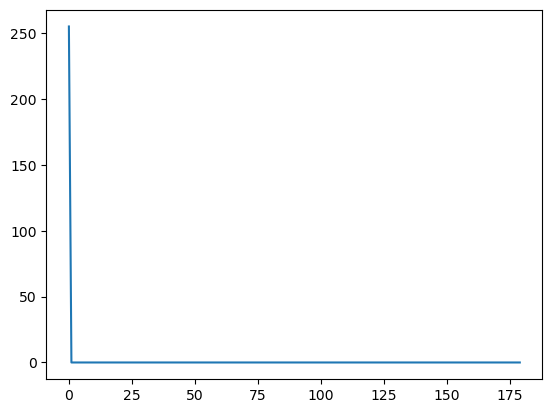

In [4]:
roi = frame[y:y+h, x:x+w]

hsv_roi =  cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

mask = cv2.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))
roi_hist = cv2.calcHist([hsv_roi],[0],mask,[180],[0,180])
cv2.normalize(roi_hist,roi_hist,0,255,cv2.NORM_MINMAX)

plt.plot(roi_hist)

In [5]:
track_window = (x,y,w,h)
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )

backSub = cv2.createBackgroundSubtractorMOG2()

while (cap.isOpened()):
 
    ret, frame = cap.read()

    if ret == True: 

        fg_mask = backSub.apply(frame)

        retval, mask_thresh = cv2.threshold( fg_mask, 100, 150, cv2.THRESH_BINARY)

        # set the kernal
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        # Apply erosion
        mask_eroded = cv2.morphologyEx(mask_thresh, cv2.MORPH_OPEN, kernel)

        # Find contours
        contours, hierarchy = cv2.findContours(mask_eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        # print(contours)
        frame_ct = cv2.drawContours(frame, contours, -1, (0, 255, 0), 2)
        # Display the resulting frame
        cv2.imshow('Frame_final', frame_ct)





        # # convert to HSV
        # hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        
        # # histogram back projection using roi_hist 
        # dst = cv2.calcBackProject([hsv],[0],roi_hist,[0,180],1)
        
        # # use meanshift to shift the tracking window
        # ret, track_window = cv2.meanShift(dst, track_window, term_crit)
        
        # # display tracked window
        # x,y,w,h = track_window

        # img = cv2.rectangle(frame, (x,y), (x+w,y+h), (0,0,255), 1)

        if cv2.waitKey(33) & 0xFF == 27: # wait a bit and exit is ESC is pressed
            break
        
    else:
        break

cv2.destroyAllWindows()
cap.release()